In [1]:
!pip install importlib-metadata==4.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install dionysus
!pip install gudhi
!pip install networkx
!pip install persim
!pip install xarray
!pip install validclust
!pip install zarr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
import os
os.chdir("/content/drive/My Drive/NASA")
!ls -ltr

total 8189
-rw------- 1 root root    1667 Oct  5 18:53  zigzagtools.py
-rw------- 1 root root   85452 Oct  5 18:53  zigzag_PD_eps_1.pdf
-rw------- 1 root root       0 Oct  5 18:53  VRrips.pk
-rw------- 1 root root  133051 Oct  5 18:53  PIs_labelled_modulo_month.pdf
-rw------- 1 root root  132779 Oct  5 18:53  PIs_labelled_modulo_month_1.pdf
-rw------- 1 root root  105850 Oct  5 18:53  PIs_labelled_modulo_month_0.pdf
-rw------- 1 root root  127787 Oct  5 18:53  PIs_labelled_1.pdf
-rw------- 1 root root  116243 Oct  5 18:53  PIs_labelled_0.pdf
-rw------- 1 root root  253295 Oct  5 18:53  PClouds.pdf
-rw------- 1 root root 1682280 Oct  5 18:53  Merra_t2m_freudenthal_Oct_2022.ipynb
-rw------- 1 root root  324306 Oct  5 18:53  Merra_t2m_freudenthal.ipynb
-rw------- 1 root root  323836 Oct  5 18:53  MERRA2_t2m_GP_20210201-20210228.nc
-rw------- 1 root root 1690684 Oct  5 18:53  MERRA2_t2m_CONUS_20210201-20210228.nc
-rw------- 1 root root  527019 Oct  5 18:53  MERRA2_t2m_CONUS_20210201-202102

In [5]:
from __future__ import print_function
import pickle
#import zigzagtools as zzt
import numpy as np
from numpy import linalg as LA
import pandas as pd
#import networkx as nx
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import dionysus as d
import matplotlib.pyplot as plt
import time
import netCDF4
import numpy as np
import gudhi as gd
#import networkx as nx
from persim import PersImage
import sys
import time
from validclust import dunn, cop, ValidClust
import itertools
from tqdm import tqdm
import itertools

In [6]:
!pip install POT==0.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os
# added
import ot
from gudhi.wasserstein import wasserstein_distance as wd
#import regrid_hp as rhp
#import cartopy.crs as ccrs
#import healpy as hp
import xarray as xr
import mpl_toolkits
#from cartopy.io import shapereader
#from mpl_toolkits.basemap import Basemap
#import ocw.utils as utils
#import ocw.data_source.local as local
#import ocw.dataset_processor as dsp
#from ocw.dataset import Bounds as Bounds
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from persim import wasserstein
from sklearn.cluster import DBSCAN
import zarr
import seaborn as sns
sns.set_theme()

In [8]:
path = os.getcwd()
#%% Parameters 
#nameFolderCloud = path + '/PointCloud/5_Dimensions/datafullpc'  # Example 1 (Dorcas)  (sizeWindow = 10) * It has not any interesting structures
#nameFolderCloud = path + '/PointCloud/FIG8Saved_40/File'  # Example 2  (sizeWindow = 12)
#nameFolderCloud = path + '/../Example_POINT_CLOUD/PointCloud/FIG8Saved_60/File'  # Example 3  (sizeWindow = 12)
#scaleParameter = 1.0 # [Example 2 and 3] Maximum Scale Parameter for Filtration (Depends on distance between points)
#scaleParameter = 9.0 # [Example 1] Maximum Scale Parameter for Filtration (Depends on distance between points)
maxDimHoles = 2 # Maximum Dimension of Holes (It means.. 0 and 1)
sizeWindow = 28 # [Example 2 and 3] Number of Point-Clouds (i.e. timestamps) 
#sizeWindow = 10 # [Example 1] Number of Point-Clouds (i.e. timestamps) 

In [9]:
def extract_PD_arrays_with_cubical_complex(data, infinity = 300.):
    cubical_complex = gd.CubicalComplex(top_dimensional_cells=data)
    PD_CC = cubical_complex.persistence()
    dim = np.array([i[0] for i in PD_CC])
    birth = np.array([i[1][0] for i in PD_CC])
    death = np.array([i[1][1] for i in PD_CC])
    death[death==np.Infinity] = infinity
    n0 = dim[dim==0].size
    n1 = dim[dim==1].size
    pd0 = np.zeros([n0, 2])
    pd1 = np.zeros([n1, 2])
    pd0[:,0] = birth[dim==0]
    pd0[:,1] = death[dim==0]
    pd1[:,0] = birth[dim==1]
    pd1[:,1] = death[dim==1]
    return cubical_complex, pd0, pd1

def calculate_wasserstein_distance(pd0_array1, pd0_array2, pd1_array1, pd1_array2, order=2):
    return wd(pd0_array1, pd0_array2, order=order) + wd(pd1_array1, pd1_array2, order=order)

In [10]:
def extract_PD_arrays_with_freudenthal_triangulation(data, lower =240., infinity = 300.):
    
    f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    birth0=np.array([dgm.birth for dgm in dgms[0]])
    death0=np.array([dgm.death for dgm in dgms[0]])
    death0[death0==np.Infinity] = infinity 
    birth1=np.array([dgm.birth for dgm in dgms[1]])
    death1=np.array([dgm.death for dgm in dgms[1]])
    death1[death1==np.Infinity] = infinity
   
    return [[birth0,death0],[birth1,death1]]

In [11]:
def plot_PDs (pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(25,15))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(4,7,1+iday)
        ax.scatter(pd0_array[iday][:,0], pd0_array[iday][:,1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][:,0], pd1_array[iday][:,1], marker='^', s=5,
               facecolors='none', edgecolor='blue', label = '1')
        
        ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
        ax.set_xlim([lower_bound, upper_bound])
        ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        #ax.set_xlabel('Birth')
        #ax.set_ylabel('Death')
        #ax.set_xticks(np.arange(4)*20+240)
        #ax.set_xticklabels(np.repeat('',4))
        #ax.set_yticks(np.arange(4)*20+240)
        #ax.set_yticklabels(np.repeat('',4))

In [12]:
def plot_Dionysus_PDs(pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,20))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(4,7,1+iday)
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5,
               facecolors='none', edgecolor='blue', label = '1')
        
        ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
        ax.set_xlim([lower_bound, upper_bound])
        ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
    plt.savefig("pds.pdf",bbox_inches='tight')
    plt.show()   
        

In [13]:
def plot_Dionysus_PDs_by_Cluster(pd0_array, pd1_array, titles, cluster_labels, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,20))
    nday = len(pd0_array)
    idx0= np.where(cluster_labels==0)[0]
    idx1= np.where(cluster_labels==1)[0]
    
    ax = fig.add_subplot(2,2,1)
    for iday in idx0:    
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
    ax = fig.add_subplot(2,2,2)
    for iday in idx0:    
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5,
            facecolors='none', edgecolor='blue', label = '1')
        
    ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
    ax.set_xlim([lower_bound, upper_bound])
    ax.set_ylim([lower_bound, upper_bound])
    #ax.set_title(titles[iday])
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    
    ax = fig.add_subplot(2,2,3)
    for iday in idx1:    
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
    ax = fig.add_subplot(2,2,4)
    for iday in idx1:    
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5,
               facecolors='none', edgecolor='blue', label = '1')
        
    ax.plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
    ax.set_xlim([lower_bound, upper_bound])
    ax.set_ylim([lower_bound, upper_bound])
    #ax.set_title(titles[iday])
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')

In [14]:
def keyfunc(s):
    return s[0:5], int(s[5:7]), s[7], int(s[8:10])

def selectChannel(dir, channelNum):
    
    #tileList = [filename for filename in os.listdir(dir) if filename.startswith("Tile")]
    tempTileList = [filename for filename in os.listdir(dir) if filename.startswith("Tile")]

    print (len(tempTileList))
    tileList = []
    for i in tempTileList:
        temp = i.replace('.', '_')
        tempList = temp.split('_')
        tempList[1] = str(tempList[1].zfill(2))
        tempList[2] = str(tempList[2].zfill(2))
        result = '_'.join(tempList)
        result = result[0:10] + '.' + result[-4:]
        tileList.append(result)
    
    dict1 = dict(zip(tileList, tempTileList))
    print (dict1)
    tileList = sorted(tileList, key=keyfunc)
    print (len(tileList))
    # take first 80 tiles for test
    tileList = tileList#[0:300]
    data = np.empty((len(tileList), 32, 32))

    for i in range(len(tileList)):
        tempData = zarr.open(dir + '//' + dict1[tileList[i]])[:, :, channelNum]
        print (dict1[tileList[i]])
        data[i, :, :] = tempData

    return data

In [15]:
'''
f = netCDF4.Dataset('MERRA2_t2m_CONUS_20210201-20210228_hp05.nc', 'r')
print(f)
'''
fname = 'MERRA2_t2m_GP_20210201-20210228.nc'
fname2 = 'Sample Data'

ds = xr.open_dataset(fname)
#data = ds['t2m'].squeeze()

lon = ds.lon
lat = ds.lat
channelNum = 7

# data2 = zarr.open(fname2 + '//' +'Tile_0_0.zarr')[:, :, 0]
data = selectChannel(fname2, channelNum)
print (np.shape(data))
p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(data[0,:])

975
{'Tile_09_38.zarr': 'Tile_9_38.zarr', 'Tile_09_35.zarr': 'Tile_9_35.zarr', 'Tile_09_05.zarr': 'Tile_9_5.zarr', 'Tile_09_04.zarr': 'Tile_9_4.zarr', 'Tile_09_36.zarr': 'Tile_9_36.zarr', 'Tile_09_06.zarr': 'Tile_9_6.zarr', 'Tile_09_09.zarr': 'Tile_9_9.zarr', 'Tile_09_07.zarr': 'Tile_9_7.zarr', 'Tile_09_37.zarr': 'Tile_9_37.zarr', 'Tile_09_08.zarr': 'Tile_9_8.zarr', 'Tile_09_34.zarr': 'Tile_9_34.zarr', 'Tile_09_33.zarr': 'Tile_9_33.zarr', 'Tile_09_28.zarr': 'Tile_9_28.zarr', 'Tile_09_30.zarr': 'Tile_9_30.zarr', 'Tile_09_29.zarr': 'Tile_9_29.zarr', 'Tile_09_03.zarr': 'Tile_9_3.zarr', 'Tile_09_32.zarr': 'Tile_9_32.zarr', 'Tile_09_31.zarr': 'Tile_9_31.zarr', 'Tile_09_26.zarr': 'Tile_9_26.zarr', 'Tile_09_27.zarr': 'Tile_9_27.zarr', 'Tile_09_23.zarr': 'Tile_9_23.zarr', 'Tile_09_25.zarr': 'Tile_9_25.zarr', 'Tile_09_21.zarr': 'Tile_9_21.zarr', 'Tile_09_17.zarr': 'Tile_9_17.zarr', 'Tile_09_22.zarr': 'Tile_9_22.zarr', 'Tile_09_18.zarr': 'Tile_9_18.zarr', 'Tile_09_19.zarr': 'Tile_9_19.zarr', 'Ti

In [16]:
#nday = 975
nday = np.shape(data)[0]

In [17]:
print (np.shape(data))

(975, 32, 32)


In [18]:
innerSizeWindow=7
lower=int(np.floor(innerSizeWindow/2))
upper=int(np.ceil(innerSizeWindow/2))

In [19]:
# plot 7 day t2m averages

In [20]:
#freudenthal_complex = []
pd0 = []
pd1 = []

#freudenthal_complex_union = []
pd0_union = []
pd1_union = []
for iday in np.arange(nday):
    # Build freudenthal_triangulation for individual day 
    p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(data[iday,:])
    #freudenthal_complex.append(cc)
    pd0.append(p0)
    pd1.append(p1)
    # Build freudenthal_triangulation for the union of two consecutive days
    #if iday != nday-1:
    #p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(0.5*data[iday,:]+0.5*data[iday+1,:])
    p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(data[iday,:])
    
    #freudenthal_complex_union.append(cc)
    pd0_union.append(p0)
    pd1_union.append(p1)

In [21]:
#titles = ['February %02d' %(iday+1) for iday in np.arange(nday)]
#plot_Dionysus_PDs(pd0_union, pd1_union, titles)

In [22]:
## Note: you must run the clustering below first in order to obtain the labels with the "best" method

In [23]:
def optimalDBSCAN(data, score_, eps, metric='euclidean', bMax=True, distType=0):
    eps_range=np.arange(eps['min'],eps['max'],eps['inc'])
    min_samples_range=range(2,10)
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9
        
    eps_ask=0
    min_samples_ask=0
    clustering_ask=None
    print("score, best_score, eps, eps_ask, min_samples, min_samples_ask")
    for min_samples in min_samples_range:
     for eps in eps_range:
      clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
      clustering.fit(data)
      if len(np.unique(clustering.labels_))>1:
        if distType==0:
            score=score_(data, clustering.labels_)
        elif distType==1:
            dist=pairwise_distances(data)
            score=score_(dist, clustering.labels_)
        elif distType==2:
            dist=pairwise_distances(data)
            score=score_(data, dist, clustering.labels_)
        if (score>best_score and bMax==True):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering
        elif(score<best_score and bMax==False):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering  
        print(score, best_score, eps, eps_ask, min_samples, min_samples_ask)
    return(best_score, eps_ask, min_samples_ask, clustering_ask)   

In [24]:
def optimalHClust(data, score_, metric='euclidean', bMax=True, distType=0):
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9
    linkage_ask = ''  
    n_ask = 2
    clustering_ask = None
    print("score, best_score, i, n_ask, linkage, linkage_ask")
    for i in range(2, 7):
     for linkage in ['complete', 'average', 'single']: 
      clustering= AgglomerativeClustering(n_clusters=i, affinity=metric, linkage=linkage)
      #clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
      clustering.fit(data)
      if len(np.unique(clustering.labels_))>1:
        if distType==0:
            score=score_(data, clustering.labels_)
        elif distType==1:
            dist=pairwise_distances(data)
            score=score_(dist, clustering.labels_)
        elif distType==2:
            dist=pairwise_distances(data)
            score=score_(data, dist, clustering.labels_)
        if (score>best_score and bMax==True):
          best_score=score
          linkage_ask=linkage
          n_ask=i
          clustering_ask=clustering
        elif(score<best_score and bMax==False):
          best_score=score
          linkage_ask=linkage
          n_ask=i 
          clustering_ask=clustering
        print(score, best_score, i, n_ask, linkage, linkage_ask)
    return(best_score, n_ask, linkage_ask, clustering_ask)

In [25]:
results = {}
results['data'] = {}
results['pis']= {}
results['pds']= {}
params = {}
params['data'] = {}
params['pis']= {}
params['pds']= {}
clusters = {}
clusters['data'] = {}
clusters['pis']= {}
clusters['pds']= {}

In [26]:
# Option 1
# Persistence image on our own
# resolution is the size of persistence image
def persistence_image(dgm, resolution = [50,50], return_raw = False, normalization = True, bandwidth = 1., power = 1.):
    PXs, PYs = dgm[:, 0:1], dgm[:, 1:2]
    xm, xM, ym, yM = PXs.min(), PXs.max(), PYs.min(), PYs.max()
    x = np.linspace(xm, xM, resolution[0])
    y = np.linspace(ym, yM, resolution[1])
    X, Y = np.meshgrid(x, y)
    Zfinal = np.zeros(X.shape)
    X, Y = X[:, :, np.newaxis], Y[:, :, np.newaxis]

    P0, P1 = np.reshape(dgm[:, 0], [1, 1, -1]), np.reshape(dgm[:, 1], [1, 1, -1])

    # Compute image
    weight = np.abs(P1 - P0)
    distpts = np.sqrt((X - P0) ** 2 + (Y - P1) ** 2)

    if return_raw:
        lw = [weight[0, 0, pt] for pt in range(weight.shape[2])]
        lsum = [distpts[:, :, pt] for pt in range(distpts.shape[2])]
    else:
        weight = weight ** power
        Zfinal = (np.multiply(weight, np.exp(-distpts ** 2 / bandwidth))).sum(axis=2)

    output = [lw, lsum] if return_raw else Zfinal

    if normalization:
        norm_output = (output - np.min(output)) / (np.max(output) - np.min(output))
    else:
        norm_output = output

    return norm_output

In [27]:
PIs = []
for iday in np.arange(nday):
    xs= np.concatenate((pd0[iday][0][:], pd1[iday][0][:]), axis=0)
    ys= np.concatenate((pd0[iday][1][:], pd1[iday][1][:]), axis=0)
    D = np.transpose([xs,ys])
    PI = persistence_image(D, resolution =(100,100), power=0.01)
    PIs.append(PI.flatten())

In [28]:
X = np.array(PIs)
X -= np.min(X)
X/= (np.max(X)-np.min(X))

In [29]:
vclust = ValidClust(
    k=list(range(2, 8)),
    methods=['hierarchical', 'kmeans'],
    indices=['silhouette', 'calinski', 'davies', 'dunn', 'cop']
)
cvi_vals = vclust.fit_predict(X)
print(cvi_vals)

                                  2            3            4            5  \
method       index                                                           
hierarchical silhouette    0.729940     0.665356     0.607400     0.619996   
             calinski    851.063362   912.252879   942.951859  1057.598077   
             davies        0.511142     0.777574     0.747467     0.693540   
             dunn          0.024284     0.015459     0.008241     0.008241   
             cop           0.063097     0.073626     0.106854     0.112235   
kmeans       silhouette    0.712771     0.737217     0.658151     0.633137   
             calinski    884.691302  1091.756233  1278.427315  1336.255556   
             davies        0.580398     0.556272     0.616268     0.619756   
             dunn          0.008394     0.019629     0.005529     0.009374   
             cop           0.060552     0.069400     0.098349     0.115492   

                                   6            7  
method     

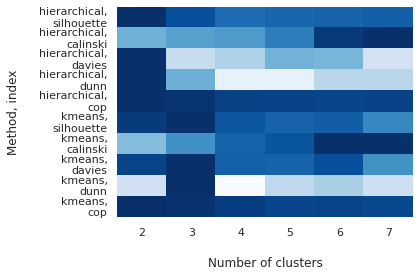

In [30]:
vclust.plot()

In [31]:
keys = cvi_vals[2]['kmeans'].keys()
for method in ['hierarchical','kmeans']:
 results['pis'][method]={}   
 for key in keys:
  if key=='davies':  
    idx=np.argmin([cvi_vals[x][method][key] for x in range(2,7)])
  else:
    idx=np.argmax([cvi_vals[x][method][key] for x in range(2,7)])
  #print(cvi_vals[2+idx][method][key])
  results['pis'][method][key]=cvi_vals[2+idx][method][key]

In [32]:
#Convert to wasserstein distance
wdist = np.zeros((nday,nday))
for i in range(nday):
  for j in range(i+1):
    wdist[i,j] = wd(X[i,].reshape(1,10000), X[j,].reshape(1,10000), order=2) #wasserstein(Di, Dj) # where the format of PD is numpy matrix
    wdist[j,i] = wdist[i,j]

In [33]:
wdist=(wdist-np.min(wdist))/(np.max(wdist)-np.min(wdist))

In [34]:
eps={'min':0.01, 'max':10, 'inc': 0.05}
results['pis']['DBSCAN']={}
params['pis']['DBSCAN']={}
clusters['pis']['DBSCAN'] = {}

In [35]:
scores=['silhouette', 'calinski', 'davies', 'dunn', 'cop']
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['pis']['DBSCAN'][score] = {}
    params['pis']['DBSCAN'][score] = {}
    clusters['pis']['DBSCAN'][score] = {}
    #[score_, eps_, min_samples_, clusters_]= optimalDBSCAN(data=X, score_=f, eps=eps, metric='euclidean', bMax=bMax, distType=distType)
    [score_, eps_, min_samples_, clusters_]= optimalDBSCAN(data=wdist, score_=f, eps=eps, metric='precomputed', bMax=bMax, distType=distType)
    
    results['pis']['DBSCAN'][score]= score_
    params['pis']['DBSCAN'][score]['eps'] = eps_
    params['pis']['DBSCAN'][score]['min_samples'] = min_samples_
    clusters['pis']['DBSCAN'][score] = clusters_
        

======silhouette======
score, best_score, eps, eps_ask, min_samples, min_samples_ask
-0.1587337806759915 -0.1587337806759915 0.060000000000000005 0.060000000000000005 2 2
0.2700472923613002 0.2700472923613002 0.11 0.11 2 2
0.31990676640383464 0.31990676640383464 0.16000000000000003 0.16000000000000003 2 2
0.3813883031997963 0.3813883031997963 0.21000000000000002 0.21000000000000002 2 2
0.4630966425527161 0.4630966425527161 0.26 0.26 2 2
0.5582168665267769 0.5582168665267769 0.31000000000000005 0.31000000000000005 2 2
0.7470841150560038 0.7470841150560038 0.36000000000000004 0.36000000000000004 2 2
0.7335766707586754 0.7470841150560038 0.41000000000000003 0.36000000000000004 2 2
0.7092293418825193 0.7470841150560038 0.46 0.36000000000000004 2 2
0.6299505573456745 0.7470841150560038 0.51 0.36000000000000004 2 2
0.6712600583630155 0.7470841150560038 0.56 0.36000000000000004 2 2
0.6861147982140123 0.7470841150560038 0.6100000000000001 0.36000000000000004 2 2
0.698336592099546 0.74708411505

In [36]:
results['pis']['Hierarchical']={}
params['pis']['Hierarchical']={}
clusters['pis']['Hierarchical'] = {}

In [37]:
scores=['silhouette', 'calinski', 'davies', 'dunn','cop']
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['pis']['Hierarchical'][score] = {}
    params['pis']['Hierarchical'][score] = {}
    clusters['pis']['Hierarchical'][score] = {}
    [score_, n, linkage, clusters_] = optimalHClust(data=wdist, score_=f, metric='precomputed', bMax=bMax, distType=distType)
    results['pis']['Hierarchical'][score]=score_
    params['pis']['Hierarchical'][score]['n']=n
    params['pis']['Hierarchical'][score]['linkage']=linkage
    clusters['pis']['Hierarchical'][score]=clusters_

======silhouette======
score, best_score, i, n_ask, linkage, linkage_ask
0.7194294634264006 0.7194294634264006 2 2 complete complete
0.7194294634264006 0.7194294634264006 2 2 average complete
0.7194294634264006 0.7194294634264006 2 2 single complete
0.6824146296385423 0.7194294634264006 3 2 complete complete
0.6824146296385423 0.7194294634264006 3 2 average complete
0.6824146296385423 0.7194294634264006 3 2 single complete
0.6777244984799304 0.7194294634264006 4 2 complete complete
0.6777244984799304 0.7194294634264006 4 2 average complete
0.6777244984799304 0.7194294634264006 4 2 single complete
0.66621529521355 0.7194294634264006 5 2 complete complete
0.66621529521355 0.7194294634264006 5 2 average complete
0.66621529521355 0.7194294634264006 5 2 single complete
0.6576777560604966 0.7194294634264006 6 2 complete complete
0.6576777560604966 0.7194294634264006 6 2 average complete
0.6576777560604966 0.7194294634264006 6 2 single complete
======calinski======
score, best_score, i, n_ask

In [38]:
results

{'data': {},
 'pis': {'hierarchical': {'silhouette': 0.7299398669149731,
   'calinski': 1306.1006304165646,
   'davies': 0.5111421723294636,
   'dunn': 0.02428388468729754,
   'cop': 0.1139323550764257},
  'kmeans': {'silhouette': 0.7372169820687431,
   'calinski': 1490.2317708153118,
   'davies': 0.5562724300563827,
   'dunn': 0.019629254847630194,
   'cop': 0.11549201465200044},
  'DBSCAN': {'silhouette': 0.7556766884387484,
   'calinski': 3001.139551352617,
   'davies': 0.1725844718402571,
   'dunn': 0.006300874530499603,
   'cop': 0.0728645905842347},
  'Hierarchical': {'silhouette': 0.7194294634264006,
   'calinski': 19.42931289733801,
   'davies': 0.1725844718402571,
   'dunn': 0.07818438947782401,
   'cop': 0.14734186620792417}},
 'pds': {}}

In [39]:
X = []
dim=np.shape(data[0,:])
for iday in np.arange(nday):
    X.append(np.array(data[iday,:]).reshape(dim[0]*dim[1]))

In [40]:
X -= np.min(X)
X/= (np.max(X)-np.min(X))

In [41]:
vclust = ValidClust(
    k=list(range(2, 8)),
    methods=['hierarchical', 'kmeans'],
    indices=['silhouette', 'calinski', 'davies', 'dunn', 'cop']
)
cvi_vals = vclust.fit_predict(X)
print(cvi_vals)

                                   2            3            4            5  \
method       index                                                            
hierarchical silhouette     0.460181     0.480958     0.393615     0.335656   
             calinski     991.832592  1118.131892  1273.895891  1202.852973   
             davies         0.692848     0.624379     0.753751     0.878345   
             dunn           0.014784     0.024848     0.024848     0.024848   
             cop            0.078376     0.117135     0.150139     0.167025   
kmeans       silhouette     0.476316     0.489319     0.413951     0.368375   
             calinski    1189.139412  1213.235081  1357.121963  1333.131790   
             davies         0.722755     0.644419     0.712244     0.804275   
             dunn           0.018142     0.027817     0.025320     0.020924   
             cop            0.075979     0.118585     0.143078     0.159235   

                                   6            7  

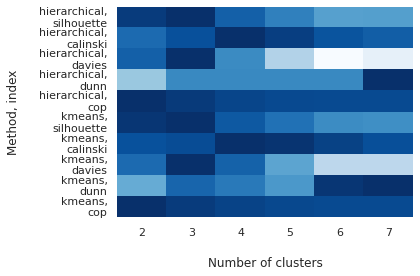

In [42]:
vclust.plot()

In [43]:
keys = cvi_vals[2]['kmeans'].keys()
for method in ['hierarchical','kmeans']:
 results['data'][method]={}   
 for key in keys:
  if key=='davies':  
    idx=np.argmin([cvi_vals[x][method][key] for x in range(2,7)])
  else:
    idx=np.argmax([cvi_vals[x][method][key] for x in range(2,7)])
  #print(cvi_vals[2+idx][method][key])
  results['data'][method][key]=cvi_vals[2+idx][method][key]

In [44]:
#Convert to wasserstein distance
wdist = np.zeros((nday,nday))
for i in range(nday):
  for j in range(i+1):
    wdist[i,j] = wd(X[i,].reshape(1,1024), X[j,].reshape(1,1024), order=2) #wasserstein(Di, Dj) # where the format of PD is numpy matrix
    wdist[j,i] = wdist[i,j]

In [45]:
wdist=(wdist-np.min(wdist))/(np.max(wdist)-np.min(wdist))

In [46]:
eps={'min':0.01, 'max':10, 'inc': 0.05}
results['data']['DBSCAN']={}
params['data']['DBSCAN']={}
clusters['data']['DBSCAN']={}

In [47]:
scores=['silhouette', 'calinski', 'davies', 'dunn', 'cop']
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['data']['DBSCAN'][score] = {}
    params['data']['DBSCAN'][score] = {}
    clusters['data']['DBSCAN'][score] = {}
    #[score_, eps_, min_samples_, clusters_]= optimalDBSCAN(data=X, score_=f, eps=eps, metric='euclidean', bMax=bMax, distType=distType)
    [score_, eps_, min_samples_, clusters_]= optimalDBSCAN(data=wdist, score_=f, eps=eps, metric='precomputed', bMax=bMax, distType=distType)
    
    results['data']['DBSCAN'][score]= score_
    params['data']['DBSCAN'][score]['eps'] = eps_
    params['data']['DBSCAN'][score]['min_samples'] = min_samples_
    clusters['data']['DBSCAN'][score]= clusters_
    
    #results['data']['DBSCAN'][score]= optimalDBSCAN(data=X, score_=f, eps=eps, metric='euclidean', bMax=bMax, distType=distType)

======silhouette======
score, best_score, eps, eps_ask, min_samples, min_samples_ask
0.14337797060699672 0.14337797060699672 0.01 0.01 2 2
0.5871124378814707 0.5871124378814707 0.060000000000000005 0.060000000000000005 2 2
0.6785650120140114 0.6785650120140114 0.11 0.11 2 2
0.7446092984125815 0.7446092984125815 0.16000000000000003 0.16000000000000003 2 2
0.7914825939827024 0.7914825939827024 0.21000000000000002 0.21000000000000002 2 2
0.8312122550199254 0.8312122550199254 0.26 0.26 2 2
0.8735928636207487 0.8735928636207487 0.31000000000000005 0.31000000000000005 2 2
0.8735928636207487 0.8735928636207487 0.36000000000000004 0.31000000000000005 2 2
0.8907599923042078 0.8907599923042078 0.41000000000000003 0.41000000000000003 2 2
0.9119278308981882 0.9119278308981882 0.46 0.46 2 2
0.9119278308981882 0.9119278308981882 0.51 0.46 2 2
0.9119278308981882 0.9119278308981882 0.56 0.46 2 2
0.9119278308981882 0.9119278308981882 0.6100000000000001 0.46 2 2
0.9193875356982739 0.9193875356982739 0.6

In [48]:
results['data']['Hierarchical']={}
params['data']['Hierarchical']={}
clusters['data']['Hierarchical'] = {}

In [49]:
scores=['silhouette', 'calinski', 'davies', 'dunn','cop']
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['data']['Hierarchical'][score] = {}
    params['data']['Hierarchical'][score] = {}
    clusters['data']['Hierarchical'][score] = {}
    [score_, n, linkage, clusters_] = optimalHClust(data=wdist, score_=f, metric='precomputed', bMax=bMax, distType=distType)
    results['data']['Hierarchical'][score]=score_
    params['data']['Hierarchical'][score]['n']=n
    params['data']['Hierarchical'][score]['linkage']=linkage
    clusters['data']['Hierarchical'][score]=clusters_

======silhouette======
score, best_score, i, n_ask, linkage, linkage_ask
0.9193875356982739 0.9193875356982739 2 2 complete complete
0.9193875356982739 0.9193875356982739 2 2 average complete
0.9193875356982739 0.9193875356982739 2 2 single complete
0.8969602783818909 0.9193875356982739 3 2 complete complete
0.8969602783818909 0.9193875356982739 3 2 average complete
0.8969602783818909 0.9193875356982739 3 2 single complete
0.8448034229742702 0.9193875356982739 4 2 complete complete
0.8448034229742702 0.9193875356982739 4 2 average complete
0.8448034229742702 0.9193875356982739 4 2 single complete
0.8466210497898656 0.9193875356982739 5 2 complete complete
0.8466210497898656 0.9193875356982739 5 2 average complete
0.8466210497898656 0.9193875356982739 5 2 single complete
0.8220804522465183 0.9193875356982739 6 2 complete complete
0.8220804522465183 0.9193875356982739 6 2 average complete
0.8220804522465183 0.9193875356982739 6 2 single complete
======calinski======
score, best_score, i,

In [50]:
results

{'data': {'hierarchical': {'silhouette': 0.4809584197724514,
   'calinski': 1273.8958913186598,
   'davies': 0.6243789599152612,
   'dunn': 0.024847622269801334,
   'cop': 0.16787429946260438},
  'kmeans': {'silhouette': 0.48931917163781846,
   'calinski': 1357.1219628233073,
   'davies': 0.6444186518733456,
   'dunn': 0.033967784475587376,
   'cop': 0.1665506537055336},
  'DBSCAN': {'silhouette': 0.9193875356982739,
   'calinski': 1054.8031822397793,
   'davies': 0.05527557462295616,
   'dunn': 0.018272190452844266,
   'cop': 0.030515720560530472},
  'Hierarchical': {'silhouette': 0.9193875356982739,
   'calinski': 160.50603508250737,
   'davies': 0.05527557462295616,
   'dunn': 0.0721982547354364,
   'cop': 0.05209170841776226}},
 'pis': {'hierarchical': {'silhouette': 0.7299398669149731,
   'calinski': 1306.1006304165646,
   'davies': 0.5111421723294636,
   'dunn': 0.02428388468729754,
   'cop': 0.1139323550764257},
  'kmeans': {'silhouette': 0.7372169820687431,
   'calinski': 1490.

In [51]:
wdist = np.zeros((nday,nday))
for i in range(nday):
  xs= np.concatenate((pd0[i][0][:], pd1[i][0][:]), axis=0)
  ys= np.concatenate((pd0[i][1][:], pd1[i][1][:]), axis=0)
  Di = np.transpose([xs,ys])
   
  for j in range(i+1):
    #print(i,j)
    xs= np.concatenate((pd0[j][0][:], pd1[j][0][:]), axis=0)
    ys= np.concatenate((pd0[j][1][:], pd1[j][1][:]), axis=0)
    Dj = np.transpose([xs,ys])
  
    wdist[i,j] = wd(Di, Dj, order=2) #wasserstein(Di, Dj) # where the format of PD is numpy matrix
    wdist[j,i] = wdist[i,j]

In [52]:
wdist=(wdist-np.min(wdist))/(np.max(wdist)-np.min(wdist))

In [53]:
eps={'min':0.01, 'max':10, 'inc': 0.005}

In [54]:
results['pds']['DBSCAN'] = {}
params['pds']['DBSCAN'] = {}
clusters['pds']['DBSCAN'] = {}

In [ ]:
scores=['silhouette', 'calinski', 'davies', 'dunn','cop']
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['pds']['DBSCAN'][score] = {}
    params['pds']['DBSCAN'][score] = {}
    clusters['pds']['DBSCAN'][score] = {}
    [score_, eps_, min_samples_, clusters_]= optimalDBSCAN(data=wdist, score_=f, eps=eps, metric='precomputed', bMax=bMax, distType=distType)
    results['pds']['DBSCAN'][score]= score_
    params['pds']['DBSCAN'][score]['eps'] = eps_
    params['pds']['DBSCAN'][score]['min_samples'] = min_samples_
    clusters['pds']['DBSCAN'][score] = clusters_
  

======silhouette======
score, best_score, eps, eps_ask, min_samples, min_samples_ask
-0.2332393360217041 -0.2332393360217041 0.015 0.015 2 2
-0.6555355047586895 -0.2332393360217041 0.019999999999999997 0.015 2 2
-0.5516751255918609 -0.2332393360217041 0.024999999999999998 0.015 2 2
-0.5873510962421938 -0.2332393360217041 0.03 0.015 2 2
-0.6245304573832479 -0.2332393360217041 0.034999999999999996 0.015 2 2
-0.5847404840169002 -0.2332393360217041 0.039999999999999994 0.015 2 2
-0.6441026310272936 -0.2332393360217041 0.045 0.015 2 2
-0.2540310018281289 -0.2332393360217041 0.049999999999999996 0.015 2 2
-0.29154122405620025 -0.2332393360217041 0.05499999999999999 0.015 2 2
0.24840326682939645 0.24840326682939645 0.05999999999999999 0.05999999999999999 2 2
0.35003487388448445 0.35003487388448445 0.06499999999999999 0.06499999999999999 2 2
0.21609676329476887 0.35003487388448445 0.06999999999999999 0.06499999999999999 2 2
0.34515062819929715 0.35003487388448445 0.07499999999999998 0.06499999

In [ ]:
results['pds']['DBSCAN']

{'silhouette': 0.46773994122945145,
 'calinski': 542.43514102157,
 'davies': 0.4589240748150523,
 'dunn': 0.00197163172257116,
 'cop': 0.14207688191666618}

In [ ]:
score='calinski'
clustering = DBSCAN(eps=params['pds']['DBSCAN'][score]['eps'], min_samples=params['pds']['DBSCAN'][score]['min_samples'], metric='precomputed')
clustering.fit(wdist)

DBSCAN(eps=0.039999999999999994, metric='precomputed', min_samples=6)

In [ ]:
clustering.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [ ]:
for key in clusters['pds']['DBSCAN'].keys():
  print(key + "," + str(clusters['pds']['DBSCAN'][key].labels_))

silhouette,[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [ ]:
results['pds']['Hierarchical'] = {}
params['pds']['Hierarchical'] = {}
clusters['pds']['Hierarchical'] = {}

In [ ]:
scores=['silhouette', 'calinski', 'davies', 'dunn','cop'] #'cop'
bMax= True
distType=0
for score in scores:
    print('======' + score + '======' )
    if(score=='silhouette'):
        f= lambda data, labels: silhouette_score(data, labels)
    elif(score=='calinski'):
        f= lambda data, labels: calinski_harabasz_score(data, labels)
    elif(score=='davies'):
        f= lambda data, labels: davies_bouldin_score(data, labels)
        bMax=False
    elif(score == 'dunn'):
        f= lambda dist, labels: dunn(dist, labels)
        distType =1
    elif(score == 'cop'):
        f= lambda data, dist, labels: cop(data, dist, labels)
        distType =2
    results['pds']['Hierarchical'][score] = {}
    params['pds']['Hierarchical'][score] = {}
    clusters['pds']['Hierarchical'][score] = {}
    [score_, n, linkage, clusters_] = optimalHClust(data=wdist, score_=f, metric='precomputed', bMax=bMax, distType=distType)
    results['pds']['Hierarchical'][score]=score_
    params['pds']['Hierarchical'][score]['n']=n
    params['pds']['Hierarchical'][score]['linkage']=linkage
    clusters['pds']['Hierarchical'][score]=clusters_
    
    


======silhouette======
score, best_score, i, n_ask, linkage, linkage_ask
0.5755753514370754 0.5755753514370754 2 2 complete complete
0.5755753514370754 0.5755753514370754 2 2 average complete
0.3542506003912756 0.5755753514370754 2 2 single complete
0.546690313050388 0.5755753514370754 3 2 complete complete
0.5362229722010342 0.5755753514370754 3 2 average complete
0.32272697368408376 0.5755753514370754 3 2 single complete
0.48945703372563854 0.5755753514370754 4 2 complete complete
0.502455774585425 0.5755753514370754 4 2 average complete
0.3226658755521238 0.5755753514370754 4 2 single complete
0.4401071651599629 0.5755753514370754 5 2 complete complete
0.24129453344169666 0.5755753514370754 5 2 average complete
0.3242153088410678 0.5755753514370754 5 2 single complete
0.4382041796101837 0.5755753514370754 6 2 complete complete
0.2378837524948376 0.5755753514370754 6 2 average complete
0.32708332494061976 0.5755753514370754 6 2 single complete
======calinski======
score, best_score, 

In [ ]:
import json
with open('results.json', 'w') as fp:
    json.dump(results, fp)

In [ ]:
results

{'data': {'hierarchical': {'silhouette': 0.4809584197724514,
   'calinski': 1273.8958913186598,
   'davies': 0.6243789599152612,
   'dunn': 0.024847622269801334,
   'cop': 0.16787429946260438},
  'kmeans': {'silhouette': 0.48931917163781846,
   'calinski': 1357.1219628233073,
   'davies': 0.6444186518733456,
   'dunn': 0.033967784475587376,
   'cop': 0.1665506537055336},
  'DBSCAN': {'silhouette': 0.9193875356982739,
   'calinski': 1054.8031822397793,
   'davies': 0.05527557462295616,
   'dunn': 0.018272190452844266,
   'cop': 0.030515720560530472},
  'Hierarchical': {'silhouette': 0.9193875356982739,
   'calinski': 160.50603508250737,
   'davies': 0.05527557462295616,
   'dunn': 0.0721982547354364,
   'cop': 0.05209170841776226}},
 'pis': {'hierarchical': {'silhouette': 0.7299398669149731,
   'calinski': 1306.1006304165646,
   'davies': 0.5111421723294636,
   'dunn': 0.02428388468729754,
   'cop': 0.1139323550764257},
  'kmeans': {'silhouette': 0.7372169820687431,
   'calinski': 1490.

In [ ]:
print("\\hline")



for result,val_result in results.items():
  data_type = result
  print(data_type)
  print("Data type")
  print("& Algorithm")
   
  for method, val_method in val_result.items():
      print("&" + method)
      for score in val_method.keys():
        print("&" + score)
      print("\\\\") 
      print("&")  
      for score,value in val_method.items():
        print("&" + str(round(value,3)))
      print("\\\\")   
print("\\hline")      

\hline
data
Data type
& Algorithm
&hierarchical
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.481
&1273.896
&0.624
&0.025
&0.168
\\
&kmeans
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.489
&1357.122
&0.644
&0.034
&0.167
\\
&DBSCAN
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.919
&1054.803
&0.055
&0.018
&0.031
\\
&Hierarchical
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.919
&160.506
&0.055
&0.072
&0.052
\\
pis
Data type
& Algorithm
&hierarchical
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.73
&1306.101
&0.511
&0.024
&0.114
\\
&kmeans
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.737
&1490.232
&0.556
&0.02
&0.115
\\
&DBSCAN
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.756
&3001.14
&0.173
&0.006
&0.073
\\
&Hierarchical
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.719
&19.429
&0.173
&0.078
&0.147
\\
pds
Data type
& Algorithm
&DBSCAN
&silhouette
&calinski
&davies
&dunn
&cop
\\
&
&0.468
&542.435
&0.459
&0.002
&0.142
\\
&Hierarchical
&silhouette
&calinski
&davie

In [ ]:
for key in clusters['pds']['Hierarchical'].keys():
  print(key + "," + str(clusters['pds']['Hierarchical'][key].labels_))

silhouette,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

In [ ]:
for key in clusters['data']['Hierarchical'].keys():
  print(key + "," + str(clusters['data']['Hierarchical'][key].labels_))

silhouette,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

In [ ]:
clusters

{'data': {'DBSCAN': {'silhouette': DBSCAN(eps=0.66, metric='precomputed', min_samples=2),
   'calinski': DBSCAN(eps=0.11, metric='precomputed', min_samples=2),
   'davies': DBSCAN(eps=0.66, metric='precomputed', min_samples=2),
   'dunn': DBSCAN(eps=0.01, metric='precomputed', min_samples=2),
   'cop': DBSCAN(eps=0.060000000000000005, metric='precomputed', min_samples=2)},
  'Hierarchical': {'silhouette': AgglomerativeClustering(affinity='precomputed', linkage='complete'),
   'calinski': AgglomerativeClustering(affinity='precomputed', linkage='complete'),
   'davies': AgglomerativeClustering(affinity='precomputed', linkage='complete'),
   'dunn': AgglomerativeClustering(affinity='precomputed', linkage='complete',
                           n_clusters=4),
   'cop': AgglomerativeClustering(affinity='precomputed', linkage='complete')}},
 'pis': {'DBSCAN': {'silhouette': DBSCAN(eps=0.31000000000000005, metric='precomputed', min_samples=3),
   'calinski': DBSCAN(eps=0.26, metric='precompute

In [ ]:
clusters.keys()

dict_keys(['data', 'pis', 'pds'])

In [ ]:
df = pd.read_excel(fname2 + '//' + 'OR_ABI-L2-FDCC-M6_G17_s20192192006196_e20192192008569_c20192192009118.Fire_Labels.xlsx')
targetLabel = np.array(df['fire'].tolist()[500:])

print (len(targetLabel))

475


In [ ]:
L2norm = {}
#targetLabel=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#      0, 0, 0, 0, 0, 0, 0], dtype='float64')

df = pd.read_excel(fname2 + '//' + 'OR_ABI-L2-FDCC-M6_G17_s20192192006196_e20192192008569_c20192192009118.Fire_Labels.xlsx')
#targetLabel = np.array(df['fire'].tolist()[0:300])
targetLabel = np.array(df['fire'].tolist())
for data in clusters.keys():
    for method in clusters[data].keys():
        for key,clustering in clusters[data][method].items():
            totalNum = np.unique(clustering.labels_)

            dictList = []
            for permute in list(itertools.permutations(totalNum)):
                tempDict = {}
                for i in range(len(totalNum)):
                    tempDict[i] = permute[i]
                dictList.append(tempDict)
            
            possibleLabels = []
            for replaceDict in dictList:
                tempLabel = np.array([replaceDict.get(item,item)  for item in clustering.labels_])
                #possibleLabels.append(tempLabel.tolist())
                possibleLabels.append((tempLabel * (1/(len(totalNum)-1))).tolist())

            tempL2Norms = []
            for l in possibleLabels:
                tempL2Norms.append(LA.norm(l - targetLabel, ord=2))

            L2norm[data + ":" + method + ":" + key] = min(tempL2Norms)

'''
modelName = list(L2norm.keys())
modelTargetL2Norm = list(L2norm.values())

fig, ax = plt.subplots(figsize =(21, 9))
barPlot = ax.barh(modelName, modelTargetL2Norm)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
ax.grid(b = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
ax.invert_yaxis()

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, str(round((i.get_width()), 2)), fontsize = 10, fontweight ='bold', color ='grey')

ax.set_title('Difference Between Model Prediction with Ground Truth (L2 Norm)', )
plt.show()
'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

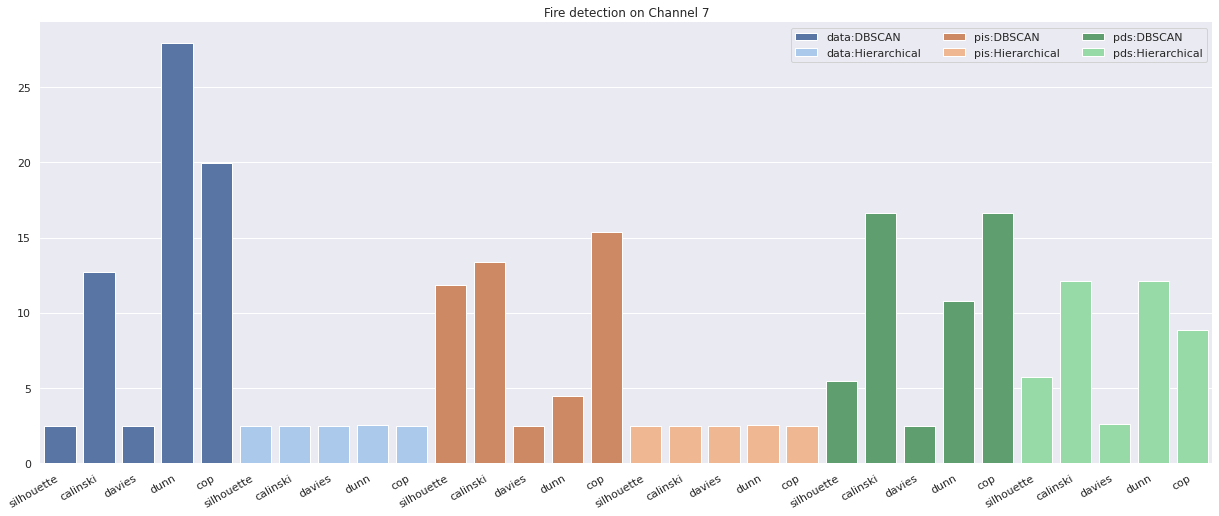

In [ ]:
oldModelName = list(L2norm.keys())
newModelName = []
for name in oldModelName:
    temp = name.split(':')[2:]
    newModelName.append(":".join(temp))

className = ['data:DBSCAN', 'data:Hierarchical', 'pis:DBSCAN', 'pis:Hierarchical', 'pds:DBSCAN', 'pds:Hierarchical']
className = np.repeat(className, 5)

data = {'modelName' : oldModelName,
        'largeClass' : className,
        'modelTargetL2Norm' : list(L2norm.values())}

df = pd.DataFrame(data)

sns.set_color_codes("pastel")
qualitative_colors_deep = sns.color_palette('deep')
qualitative_colors_light = sns.color_palette('pastel')
palette = {
    'data:DBSCAN' : qualitative_colors_deep[0],
    'data:Hierarchical' : qualitative_colors_light[0],
    'pis:DBSCAN' : qualitative_colors_deep[1],
    'pis:Hierarchical' : qualitative_colors_light[1],
    'pds:DBSCAN' : qualitative_colors_deep[2],
    'pds:Hierarchical' : qualitative_colors_light[2],
}

f, ax = plt.subplots(figsize=(21, 9))
ax = sns.barplot(x=oldModelName, y='modelTargetL2Norm', data=df, hue='largeClass', dodge=False, palette=palette)
#ax = sns.barplot(x=oldModelName, y='modelTargetL2Norm', data=df, hue='largeClass', dodge=False)
plt.title("Fire detection on Channel {}".format(channelNum))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax.legend(ncol=3, loc="upper right", frameon=True)
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set_xticklabels(newModelName)
#for p in ax.patches:
#    ax.annotate("%.2f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
#            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

sns.despine(left=True, bottom=True)
ax.get_figure().autofmt_xdate()
plt.savefig("Fire detection on Channel {} all tile.png".format(channelNum))
files.download("Fire detection on Channel {} all tile.png".format(channelNum)) 

In [ ]:
'''
i=0
labels=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      0, 0, 0, 0, 0, 0, 0], dtype='float64')
idx=np.where(labels==min(labels))
labels[idx]=np.nan
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(28),labels + i, linestyle="",marker=".", color='black')
yticks = ['Ground Truth']
print(yticks)
for data in clusters.keys():
 print(data)
 for method in clusters[data].keys():
  for key,clustering in clusters[data][method].items():
    i+=1    
    unique_labels=np.unique(clustering.labels_)
    #print(unique_labels)
    labels=np.array([1]*28, dtype='float32')
    if len(unique_labels)==2:
      clustering.labels_=np.abs(clustering.labels_)
      idx=np.where(clustering.labels_==min(clustering.labels_))   
      labels[idx]=np.nan
      plt.plot(range(len(labels)),labels + i, linestyle="",marker=".", color='blue')
    else:
      colors=['lightblue','yellow', 'blue','gray', 'darkblue', 'cyan', 'darkgray']
      for label in unique_labels:
        if label !=0:
          idx=np.where(clustering.labels_==label)
          labels[idx]=1
          plt.plot(idx[0],labels[idx] + i, linestyle="",marker=".", color=colors[label+1])

    #print(key + "," + str(labels))
    print(key + "," + str(clustering.labels_))
    yticks.append(data + ":" + method + ":" + key)
print ("Test for yticks: {}".format(yticks))
plt.xlim([0, 28])
plt.ylim([0, len(yticks)+1])
plt.yticks(range(1,len(yticks)+1), yticks)
plt.savefig("morse.pdf")
plt.show()
'''

'\ni=0\nlabels=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\n      0, 0, 0, 0, 0, 0, 0], dtype=\'float64\')\nidx=np.where(labels==min(labels))\nlabels[idx]=np.nan\nplt.figure(num=None, figsize=(16, 10), dpi=80, facecolor=\'w\', edgecolor=\'k\')\nplt.plot(range(28),labels + i, linestyle="",marker=".", color=\'black\')\nyticks = [\'Ground Truth\']\nprint(yticks)\nfor data in clusters.keys():\n print(data)\n for method in clusters[data].keys():\n  for key,clustering in clusters[data][method].items():\n    i+=1    \n    unique_labels=np.unique(clustering.labels_)\n    #print(unique_labels)\n    labels=np.array([1]*28, dtype=\'float32\')\n    if len(unique_labels)==2:\n      clustering.labels_=np.abs(clustering.labels_)\n      idx=np.where(clustering.labels_==min(clustering.labels_))   \n      labels[idx]=np.nan\n      plt.plot(range(len(labels)),labels + i, linestyle="",marker=".", color=\'blue\')\n    else:\n      colors=[\'lightblue\',\'yellow\', \'blue\',\'gr

In [ ]:
#cluster_labels = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#       0, 0, 0, 0, 0])
#plot_Dionysus_PDs_by_Cluster(pd0_union, pd1_union, titles, clustering.labels_)

In [ ]:
#idx0= np.where(clustering.labels_==0)[0]
#idx1= np.where(clustering.labels_!=0)[0]

In [ ]:
'''
dim0_xs_cl0 = np.array([])
dim0_ys_cl0 = np.array([])
dim1_xs_cl0 = np.array([])
dim1_ys_cl0 = np.array([])
for day in idx0:
    dim0_xs_cl0= np.concatenate((dim0_xs_cl0, pd0_union[day][0]))
    dim0_ys_cl0= np.concatenate((dim0_ys_cl0, pd0_union[day][1]))
    dim1_xs_cl0= np.concatenate((dim1_xs_cl0, pd1_union[day][0]))
    dim1_ys_cl0= np.concatenate((dim1_ys_cl0, pd1_union[day][1]))
'''

'\ndim0_xs_cl0 = np.array([])\ndim0_ys_cl0 = np.array([])\ndim1_xs_cl0 = np.array([])\ndim1_ys_cl0 = np.array([])\nfor day in idx0:\n    dim0_xs_cl0= np.concatenate((dim0_xs_cl0, pd0_union[day][0]))\n    dim0_ys_cl0= np.concatenate((dim0_ys_cl0, pd0_union[day][1]))\n    dim1_xs_cl0= np.concatenate((dim1_xs_cl0, pd1_union[day][0]))\n    dim1_ys_cl0= np.concatenate((dim1_ys_cl0, pd1_union[day][1]))\n'

In [ ]:
'''
dim0_xs_cl1 = np.array([])
dim0_ys_cl1 = np.array([])
dim1_xs_cl1 = np.array([])
dim1_ys_cl1 = np.array([])
for day in idx1:
    dim0_xs_cl1= np.concatenate((dim0_xs_cl1, pd0_union[day][0]))
    dim0_ys_cl1= np.concatenate((dim0_ys_cl1, pd0_union[day][1]))
    dim1_xs_cl1= np.concatenate((dim1_xs_cl1, pd1_union[day][0]))
    dim1_ys_cl1= np.concatenate((dim1_ys_cl1, pd1_union[day][1]))
'''

'\ndim0_xs_cl1 = np.array([])\ndim0_ys_cl1 = np.array([])\ndim1_xs_cl1 = np.array([])\ndim1_ys_cl1 = np.array([])\nfor day in idx1:\n    dim0_xs_cl1= np.concatenate((dim0_xs_cl1, pd0_union[day][0]))\n    dim0_ys_cl1= np.concatenate((dim0_ys_cl1, pd0_union[day][1]))\n    dim1_xs_cl1= np.concatenate((dim1_xs_cl1, pd1_union[day][0]))\n    dim1_ys_cl1= np.concatenate((dim1_ys_cl1, pd1_union[day][1]))\n'

In [ ]:
'''
mydict0x = {'Normal': dim0_xs_cl0, 'Outlier': dim0_xs_cl1}
 
dict_df0x = pd.DataFrame({ key:pd.Series(value) for key, value in mydict0x.items() })

mydict0y = {'Normal': dim0_ys_cl0, 'Outlier': dim0_ys_cl1}
 
dict_df0y = pd.DataFrame({ key:pd.Series(value) for key, value in mydict0y.items() })

mydict1x = {'Normal': dim1_xs_cl0, 'Outlier': dim1_xs_cl1}
 
dict_df1x = pd.DataFrame({ key:pd.Series(value) for key, value in mydict1x.items() })

mydict1y = {'Normal': dim1_ys_cl0, 'Outlier': dim1_ys_cl1}
 
dict_df1y = pd.DataFrame({ key:pd.Series(value) for key, value in mydict1y.items() })
'''

"\nmydict0x = {'Normal': dim0_xs_cl0, 'Outlier': dim0_xs_cl1}\n \ndict_df0x = pd.DataFrame({ key:pd.Series(value) for key, value in mydict0x.items() })\n\nmydict0y = {'Normal': dim0_ys_cl0, 'Outlier': dim0_ys_cl1}\n \ndict_df0y = pd.DataFrame({ key:pd.Series(value) for key, value in mydict0y.items() })\n\nmydict1x = {'Normal': dim1_xs_cl0, 'Outlier': dim1_xs_cl1}\n \ndict_df1x = pd.DataFrame({ key:pd.Series(value) for key, value in mydict1x.items() })\n\nmydict1y = {'Normal': dim1_ys_cl0, 'Outlier': dim1_ys_cl1}\n \ndict_df1y = pd.DataFrame({ key:pd.Series(value) for key, value in mydict1y.items() })\n"

In [ ]:
'''
#plt.figure(num=None, figsize=(25, 15), dpi=80, facecolor='w', edgecolor='k')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), dpi=80)

#pd_dim0_xs_cl0.plot(kind = "hist", density = True, bins = 50) # change density to true, because KDE uses density
dict_df0x.plot(ax=axes[0,0],kind = "kde", title="Dimension 0", color='red', style=['-','--'])
axes[0,0].set_xlabel("Birth")
#pd_dim0_xs_cl0.plot(kind = "hist", density = True, bins = 50) # change density to true, because KDE uses density
dict_df0y.plot(ax=axes[0,1], kind = "kde", title="Dimension 0", color='red', style=['-','--'])
axes[0,1].set_xlabel("Death")
dict_df1x.plot(ax=axes[1,0],kind = "kde", title="Dimension 1", color='blue', style=['-','--'])
axes[1,0].set_xlabel("Birth")
#pd_dim0_xs_cl0.plot(kind = "hist", density = True, bins = 50) # change density to true, because KDE uses density
dict_df1y.plot(ax=axes[1,1], kind = "kde", title="Dimension 1", color='blue', style=['-','--'])
axes[1,1].set_xlabel("Death")
plt.savefig('clusters_2norm.pdf', bbox_inches='tight')
plt.show()
'''